In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime, timedelta
import pickle
import plotly.offline as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
import seaborn as sns

C:\Users\Jonas\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


C:\Users\Jonas\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




In [2]:
turbine_readings = pickle.load(open("./data/turbine_readings_5mins.pickle","rb")) 
weather_data = pd.read_csv("hourly_weather_data.csv")
print(weather_data.shape)

(9019, 45)


Preprocessing both turbine data and weather data.

In [3]:
weather_data = weather_data.dropna(axis=1, how="all")
weather_data.fillna(method="ffill", inplace=True)
weather_data["timestamp"] = pd.to_datetime(weather_data["valid_time_gmt"], unit="s") - pd.Timedelta("08:00:00")
weather_data["weather_date"] = weather_data["timestamp"].dt.date
weather_data["weather_time"] = weather_data["timestamp"].dt.time
weather_data["weather_month"] = weather_data["timestamp"].dt.month
weather_data["weather_day_of_month"] = weather_data["timestamp"].dt.day
weather_data["weather_day_of_week"] = weather_data["timestamp"].dt.dayofweek

turbine_readings["turbine_date"] = turbine_readings["timestamp"].dt.date
turbine_readings["turbine_time"] = turbine_readings["timestamp"].dt.time
turbine_readings["turbine_month"] = turbine_readings["timestamp"].dt.month
turbine_readings["turbine_day_of_month"] = turbine_readings["timestamp"].dt.day
turbine_readings["turbine_day_of_week"] = turbine_readings["timestamp"].dt.dayofweek

turbine_names = [col for col in turbine_readings if col.startswith("kW")]

count = 1
for index, row in turbine_readings.iterrows():
    if count == 101:
        count = 1
    turbine_readings.loc[index, "reading_in_week"] = count
    count += 1
    turbine = turbine_readings.loc[index, turbine_names]
    turbine_readings.loc[index, "median_kW_reading"] = turbine.median()
    turbine_readings.loc[index, "avg_kW_reading"] = turbine.mean()

feature_dict = {"wspd" : "Windspeed (mph)",
                "wdir" : "Wind Direction (azimuth)",
                "temp" : "Temperature (Fahrenheit)",
                "feels_like" : "Feels Like Temperature (Fahrenheit)"}

Subset weather data to only include time range of turbine readings.

In [4]:
max_date_readings = max(turbine_readings["timestamp"])
weather_data = weather_data.loc[weather_data["timestamp"] <= max_date_readings]
print(weather_data.shape)

(650, 32)


In [5]:
for feature in feature_dict:
    trace1 = go.Scatter(
        x=turbine_readings["timestamp"],
        y=turbine_readings["avg_kW_reading"],
        mode="lines",
        name="Average Turbine Reading"
    )

    trace2 = go.Scatter(
        x=weather_data["timestamp"],
        y=weather_data[feature],
        mode="lines",
        name=feature_dict[feature],
        yaxis="y2"
    )

    data = [trace1, trace2]
    layout = go.Layout(
        title='Turbine Output vs. ' + feature_dict[feature],
        yaxis=dict(
            title='Turbine Output (kWh)',
            titlefont=dict(
                color='#1f77b4'
            ),
            tickfont=dict(
                color='#1f77b4'
            )
        ),
        yaxis2=dict(
            title=feature_dict[feature],
            titlefont=dict(
                color='#ff7f0e'
            ),
            tickfont=dict(
                color='#ff7f0e'
            ),
            overlaying='y',
            side='right'
        )
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [6]:
turbine_weather_df = pd.merge_asof(left=turbine_readings, right=weather_data, on="timestamp", direction="nearest")
turbine_weather_df.to_csv("./data/turbine&weather_combined_5mins.csv", index=False)
pickle_out = open("./data/turbine&weather_combined_5mins.pickle", "wb")
pickle.dump(turbine_weather_df, pickle_out)
pickle_out.close()

In [7]:
for feature in feature_dict:
    trace = go.Scatter(x=turbine_weather_df[feature],
                       y=turbine_weather_df["avg_kW_reading"],
                       mode='markers',
                       opacity=.8)
    data=[trace]

    layout = go.Layout(
        title='Turbine Output vs. ' + feature_dict[feature],
        yaxis=dict(
            title='Turbine Output (kWh)'
        ),
        xaxis=dict(
            title=feature_dict[feature]
        )
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

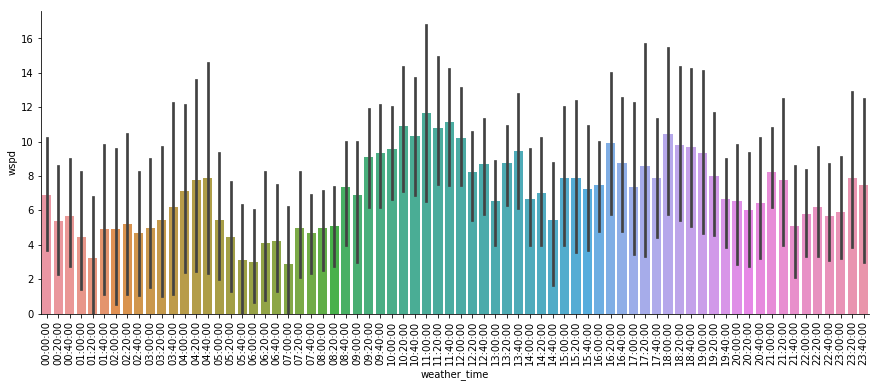

In [8]:
fig = sns.catplot(x="weather_time" ,y="wspd", data=weather_data, kind='bar', aspect=2.5, ci=95, n_boot=1000)
fig.set_xticklabels(rotation=90)

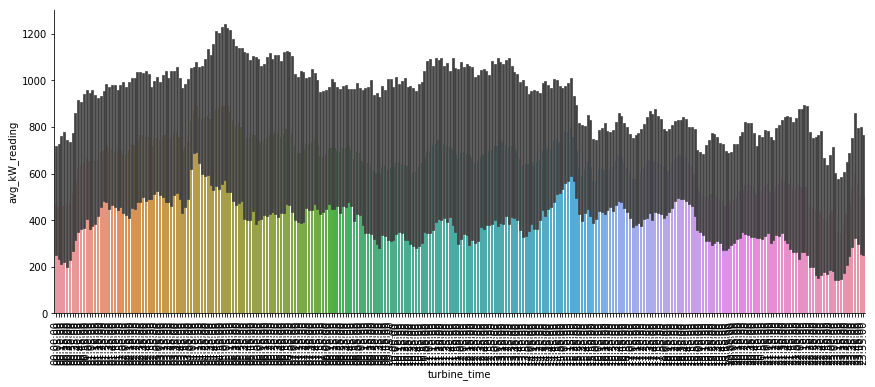

In [9]:
fig = sns.catplot(x="turbine_time" ,y="avg_kW_reading", data=turbine_readings, kind='bar', aspect=2.5, ci=95, n_boot=1000)
fig.set_xticklabels(rotation=90)

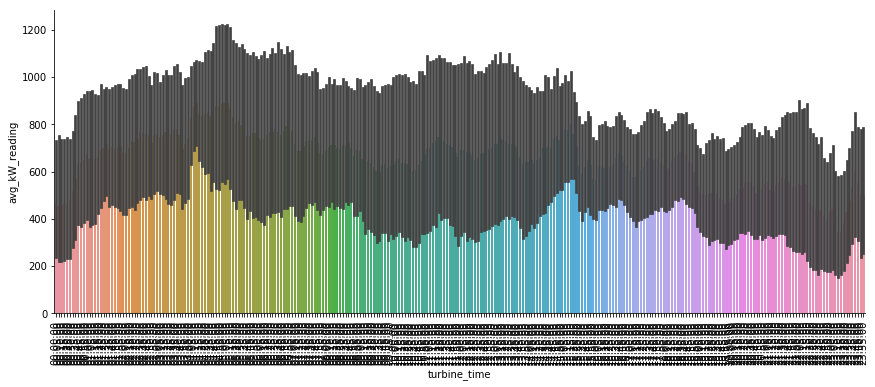

In [10]:
turbine_readings = turbine_readings.sort_values(by=["turbine_time"])
fig = sns.catplot(x="turbine_time" ,y="avg_kW_reading", data=turbine_readings, kind='bar', aspect=2.5, ci=95, n_boot=1000)
fig.set_xticklabels(rotation=90)

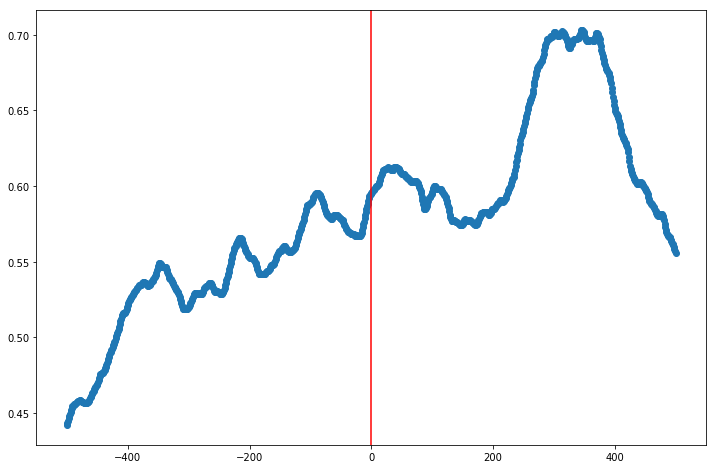

In [11]:
plt.figure(figsize=(12, 8))
plt.xcorr(turbine_weather_df["wspd"], turbine_weather_df["avg_kW_reading"], maxlags=500, normed=True, usevlines=False)
plt.axvline(x=0, color="red")